In [1]:

from template_match import read_image_rgb, read_image_gray, template_match, \
    detect_points, find_tolerance_limit, simplify_points, point_to_bbox, agglomerative_clustering, meanshift_clustering

from process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale

from hough_transform import calc_gradients, build_hough_model, fill_accumulator, \
    normalize_map, get_first_N_maximums

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi
from tqdm.notebook import tqdm

In [3]:
from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [4]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=20)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

def draw_points_on_image(
        points: np.ndarray, image: np.ndarray, w: int, h: int,
        markersize=20, alpha=0.5, color="C0"
) -> None:
    x = np.copy(points[:, 0])
    y = np.copy(points[:, 1])
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, alpha=alpha, s=markersize, color=color)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [5]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv
from setup_logger import logger


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

# DESKTOP_PATH = pathlib.Path(os.getenv("DESKTOP_PATH"))

## Step-by-step pipeline

In [7]:
PLOT_NUMBER = 7
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot9_marker{MARKER_NUMBER}.png"

# PLOT_PATH = DATA_PATH / "generated_plots" / f"plot_{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "generated_plots" / "markers" / f"plot_{PLOT_NUMBER}_marker_{MARKER_NUMBER}.png"

### 1) Draw image and marker

In [8]:
source_image = read_image_rgb(PLOT_PATH)

template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

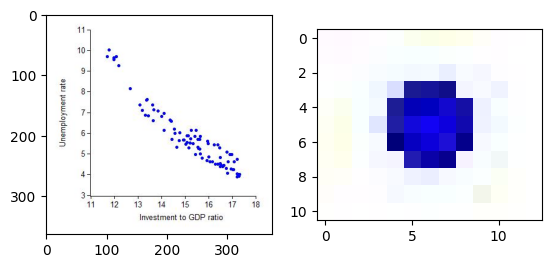

In [9]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

### 2) Template treshholding

([], [])

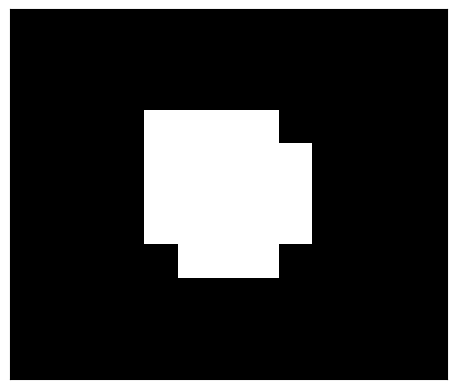

In [10]:
mask = template_tresholding(template_rgb, 230)

fig = plt.figure()
draw_image(mask)
plt.xticks([])
plt.yticks([])

In [11]:
# fig.savefig(DESKTOP_PATH / "plot9_marker2_mask.png")

In [12]:
# indexes_background = np.where(mask == 0)
# template = np.copy(template_rgb)
# template[indexes_background] = 0

In [13]:
# fig = plt.figure()
# draw_image(template)
# plt.xticks([])
# plt.yticks([])

In [14]:
# fig.savefig(DESKTOP_PATH / "plot9_marker2_masked_template.png")

**Replace black pixels**

In [15]:
image = np.copy(source_image)
template = np.copy(template_rgb)

In [16]:
zero_indexes_image = np.where((image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0))
zero_indexes_template = np.where((template[:, :, 0] == 0) & (template[:, :, 1] == 0) & (template[:, :, 2] == 0))
y_img, x_img = zero_indexes_image
y_tpl, x_tpl = zero_indexes_template

print("Number of black pixels on source image: ", len(zero_indexes_image[0]))
print("Number of black pixels on template: ", len(zero_indexes_template[0]))

Number of black pixels on source image:  236
Number of black pixels on template:  0


In [17]:
image[y_img, x_img, :] = 10
template[y_tpl, x_tpl, :] = 10

**Image tresholding**

In [18]:
# image_mask = template_tresholding(source_image)

# indexes_background = np.where(image_mask == 0)
# # image_tresholded = np.copy(source_image)
# image_tresholded = np.copy(image)
# image_tresholded[indexes_background] = 0

# plt.subplot(1, 2, 1)
# draw_image(image_mask)

# plt.subplot(1, 2, 2)
# draw_image(image_tresholded)

In [19]:
# balck_gradient = np.arange(0, 100).reshape(10, 10)
# balck_gradient_rgb = np.zeros((balck_gradient.shape[0], balck_gradient.shape[1], 3))
# balck_gradient_rgb[:, :, 0] = balck_gradient
# balck_gradient_rgb[:, :, 1] = balck_gradient
# balck_gradient_rgb[:, :, 2] = balck_gradient
# # balck_gradient.reshape(10, 10)

In [20]:
# imshow_interactive(balck_gradient_rgb)

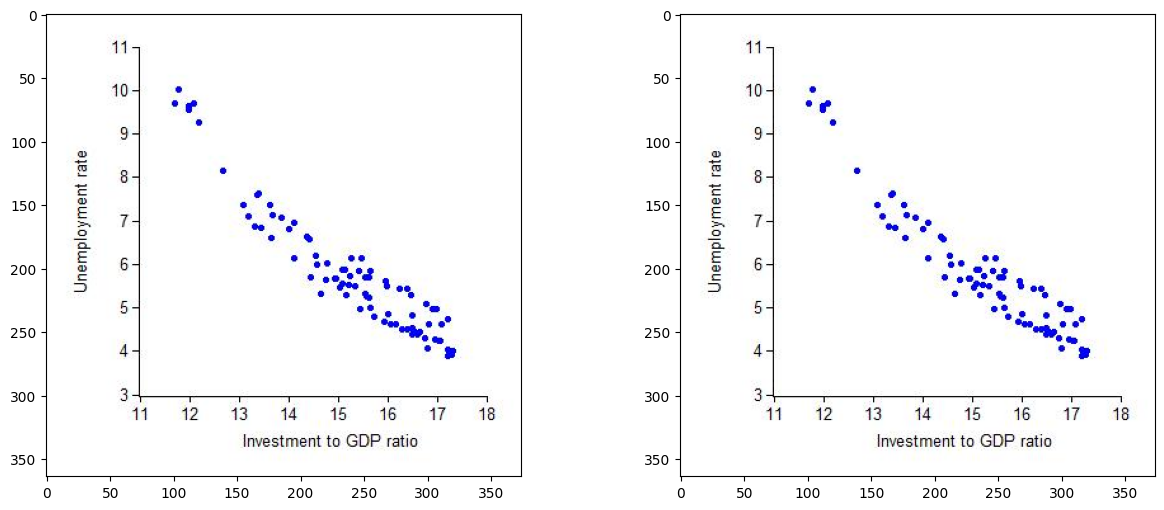

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(image)

### 3) Template match, get convolution map

In [24]:
# method_name = 'IMAGE_MASK_TM_CCORR_NORMED'
# method = "cv.TM_CCORR_NORMED"

# method_name = 'IMAGE_MASK_TM_SQDIFF_NORMED'  # НЕ РАБОТАЕТ ВОООБЩЕ, не использовать
# method = "cv.TM_SQDIFF_NORMED"


method_name = 'TM_SQDIFF_NORMED'
method = "cv.TM_SQDIFF_NORMED"

# method_name = 'TM_CCORR_NORMED'
# method = "cv.TM_CCORR_NORMED"

# method_name = 'TM_CCOEFF_NORMED'
# method = "cv.TM_CCOEFF_NORMED"

# method_name = 'TM_SQDIFF'
# method = "cv.TM_SQDIFF"


# convolution_map, _ = template_match(source_image, template_rgb, mask, method)
convolution_map, _ = template_match(image, template_rgb, mask, method)
# convolution_map, _ = template_match(image_tresholded, template, mask, method)


# convolution_map = cv.matchTemplate(source_image, template_rgb, cv.TM_CCORR_NORMED, mask=mask)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.4644318)
DEBUG - template_match.py - template_match: Convolution map was inverted


**Experimental feature: combine template matching and Hough transform**

In [25]:
# ## Hough transfrom
# hough_model = build_hough_model(template_rgb)
# accumulator = fill_accumulator(hough_model, source_image)
# accumulator_normed = normalize_map(accumulator)

# # (подгон) ((но работает))
# # обрезаем аккумулятор так, чтобы его размер был равен размеру корреляционной карты
# x_min = w // 2
# y_min = h // 2
# if w % 2 == 0:
#     x_max = accumulator_normed.shape[1] - w // 2
# else:
#     x_max = accumulator_normed.shape[1] - w // 2 - 1

# if h % 2 == 0:
#     y_max = accumulator_normed.shape[0] - h // 2
# else:
#     y_max = accumulator_normed.shape[0] - h // 2 - 1

# accumulator_normed_cropped = crop_image(accumulator_normed, bbox=(x_min, x_max, y_min, y_max))

# convolution_map_normed = normalize_map(convolution_map)

# assert convolution_map_normed.shape == accumulator_normed_cropped.shape

# convolution_map = convolution_map_normed + accumulator_normed_cropped

In [26]:
nan_indexes = np.where( np.isnan(convolution_map) )
inf_indexes = np.where( np.isinf(convolution_map) )
print("Number of NaN values:", len(nan_indexes[0]))
print("Number of inf values:", len(inf_indexes[0]))

convolution_map[nan_indexes] = 0
convolution_map[inf_indexes] = 0

convolution_map = normalize_map(convolution_map)

Number of NaN values: 0
Number of inf values: 0


In [55]:
imshow_interactive(convolution_map, width=800, height=700)

In [448]:
# fig.write_image(
#     DATA_PATH / "results" / "correlation_maps_png" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
#     scale=2
# )

# fig.write_html(
#     DATA_PATH / "results" / "correlation_maps_html" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.html",
# )

#### Find first N maximums on convolution map

In [38]:
maximums

points = [ m[1] for m in maximums ]
np.array(points)

array([[145, 149],
       [197, 240],
       [258, 294],
       [231, 263],
       [226, 249],
       [192, 207],
       [239, 295],
       [154, 153],
       [239, 305],
       [118, 133]])

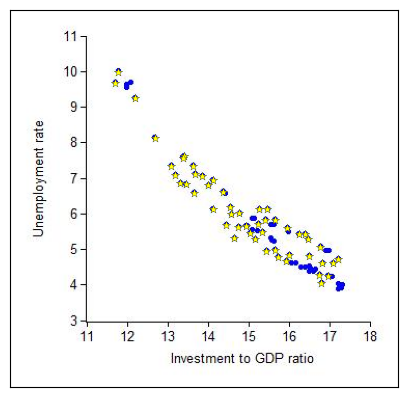

In [51]:
# example
N = 50
maximums = get_first_N_maximums(convolution_map, N)
y_points = np.array( [pt[1][0] for pt in maximums] )
x_points = np.array( [pt[1][1] for pt in maximums] )
points = np.stack((x_points, y_points)).T
x = points[:, 0]
y = points[:, 1]
x += w // 2
y += h // 2

## founded points on original image
plt.figure(figsize=(5, 5))
draw_image(source_image)

plt.scatter(x, y, s=40, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
plt.xticks([]); plt.yticks([]);

#### Interactive: find first N maximums

In [45]:
MAXIMUMS_NUMBER_LIMIT = 300

In [54]:
@interact(N_maximums=widgets.FloatSlider(value=1, min=1, max=MAXIMUMS_NUMBER_LIMIT, step=1),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(N_maximums, eps):

    ## get max points
    N_maximums = int(N_maximums)
    maximums = get_first_N_maximums(convolution_map, N_maximums)
    y_points = np.array( [pt[1][0] for pt in maximums] )
    x_points = np.array( [pt[1][1] for pt in maximums] )
    points = np.stack((x_points, y_points)).T

    ## clustering
    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    x += w // 2
    y += h // 2
    plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"{N_maximums=}")
    # plt.xlim(1110, 1960)
    # plt.xlim(1110, 1960)
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=1.0, description='N_maximums', max=300.0, min=1.0, step=1.0), FloatSli…

#### Convert point on convolution map to bbox on source image

In [73]:
index = np.where( convolution_map == 1.1025982)

# check
convolution_map[index]

array([], dtype=float32)

In [122]:
point_on_map = (index[0][0], index[1][0])

print(index)
print(point_on_map)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
bbox = point_to_bbox(*point_on_map, w, h, convolution_map)
x_min, x_max, y_min, y_max = bbox

In [17]:
assert source_image[y_min:y_max+1, x_min:x_max+1].shape == template_rgb.shape

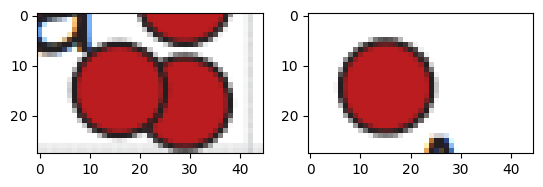

In [18]:
plt.subplot(1, 2, 1)
draw_image(source_image[y_min:y_max+1, x_min:x_max+1])


plt.subplot(1, 2, 2)
draw_image(template_rgb)

### Detect points example

In [164]:
tolerance = 0.18

max_val = np.max(convolution_map)
points = detect_points(convolution_map, max_val, tolerance=tolerance)
x = points[:, 0]
y = points[:, 1]

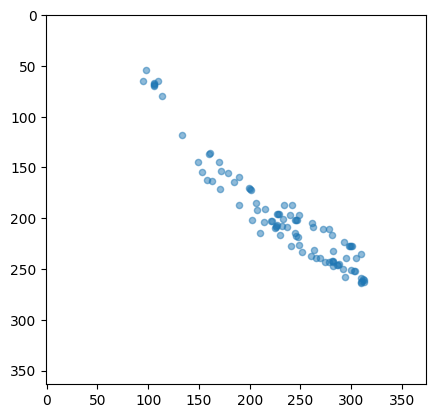

In [165]:
draw_points_on_canvas(points, source_image)

### 4) Find detection tolerance limit

In [310]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

1.551

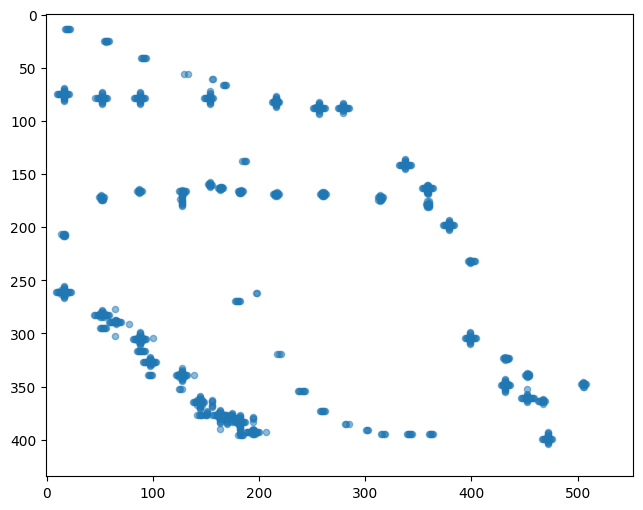

In [311]:
# run detection with limit tolerance value
max_val = np.max(convolution_map)
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)

plt.figure(figsize=(10, 6))
draw_points_on_canvas(points, source_image)
# plt.yticks(np.arange(0, 450, 50), fontsize=7)
# plt.xticks(np.arange(0, 700, 100), fontsize=7)
# points.shape
None

### Clustering example

In [197]:
%%time
bandwidth = 1
cluster_labels = meanshift_clustering(points, bandwidth)

CPU times: user 57.1 ms, sys: 17 ms, total: 74 ms
Wall time: 72.2 ms


In [198]:
cluster_centers = simplify_points(points, cluster_labels)

([], [])

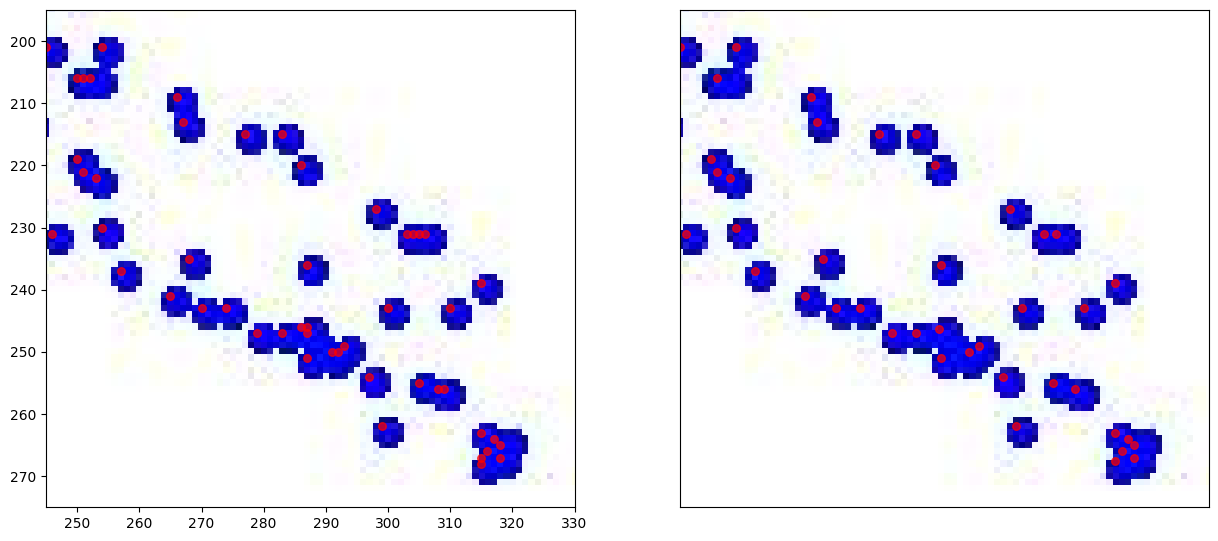

In [199]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
draw_points_on_image(points, source_image, w, h, markersize=30, alpha=0.7, color="red")
plt.xlim(245, 330); plt.ylim(275, 195)
# plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_points_on_image(cluster_centers, source_image, w, h, markersize=30, alpha=0.7, color="red")
plt.xlim(245, 330); plt.ylim(275, 195)
plt.xticks([]); plt.yticks([])

In [203]:
%%time
eps = 2
cluster_labels = agglomerative_clustering(points, eps)

CPU times: user 1.86 ms, sys: 626 µs, total: 2.49 ms
Wall time: 1.83 ms


In [204]:
cluster_centers = simplify_points(points, cluster_labels)

([], [])

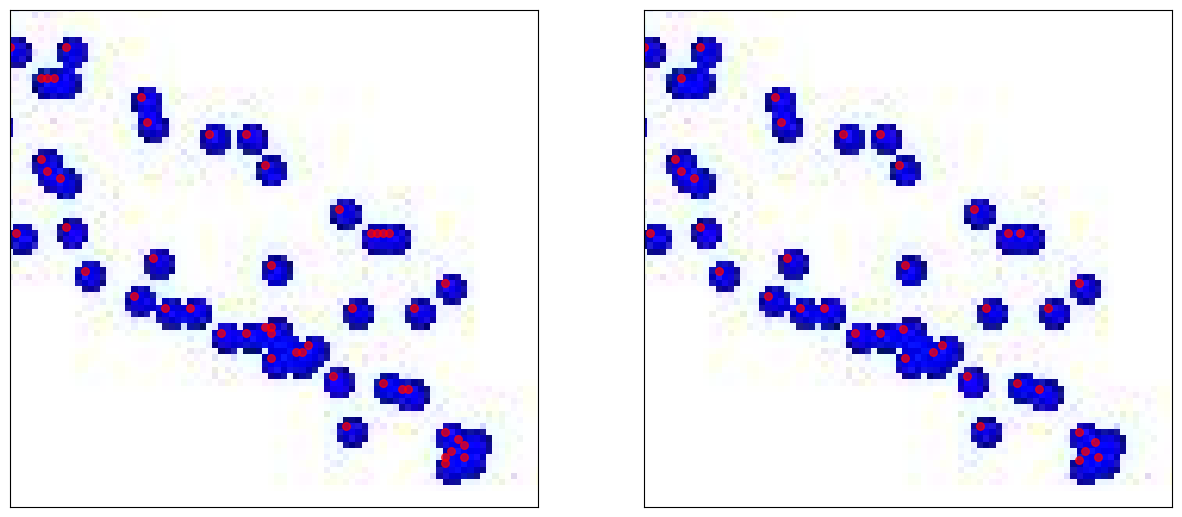

In [205]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
draw_points_on_image(points, source_image, w, h, markersize=30, alpha=0.7, color="red")
plt.xlim(245, 330); plt.ylim(275, 195)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_points_on_image(cluster_centers, source_image, w, h, markersize=30, alpha=0.7, color="red")
plt.xlim(245, 330); plt.ylim(275, 195)
plt.xticks([]); plt.yticks([])

In [206]:
from sklearn.datasets import make_blobs

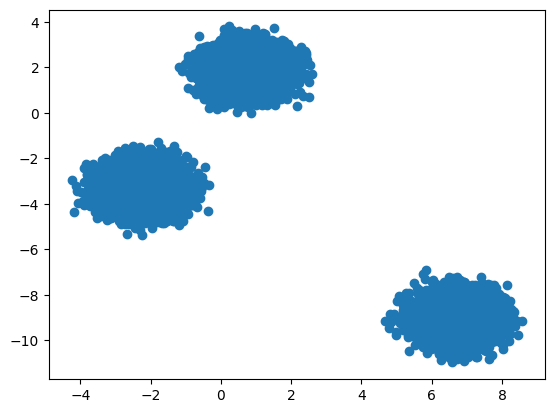

In [239]:
test_points = make_blobs(n_samples=40000, n_features=2, cluster_std=0.5)[0]

x = test_points[:, 0]
y = test_points[:, 1]
plt.scatter(x, y)

In [241]:
%%time
bandwidth = 5
cluster_labels1 = meanshift_clustering(test_points, bandwidth)

KeyboardInterrupt: 

In [240]:
%%time
eps = 2
cluster_labels2 = agglomerative_clustering(test_points, eps)

CPU times: user 46.8 s, sys: 3.53 s, total: 50.4 s
Wall time: 50.5 s


In [234]:
cluster_labels1 == cluster_labels2

array([False, False, False, ..., False, False, False])

**Clustering metrics**

In [216]:
# from scipy.spatial import distance
# n = len(points)

# rho = []
# I = []

# for i in range(n):
#     for j in range(i+1, n):
#         dist = distance.euclidean(points[i], points[j])
#         # print(dist)
#         I.append(labels_pred[i] == labels_pred[j])
#         rho.append(dist)

# I = np.array(I)
# rho = np.array(rho)

# I_f0 = I.astype(np.float64)
# I_f1 = 1 - I_f0

In [217]:
# F0 = np.sum(rho * I_f0) / np.sum(I_f0)
# F1 = np.sum(rho * I_f1) / np.sum(I_f1)

# F0, F1, F0 / F1

(18.61327050183725, 172.2479746536529)

### 5) (old) Select best tolerance and eps


Need gloabal variables `convolution_map`, `max_val`, `w`, `h`

In [312]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    # plt.xlim(1110, 1960)
    # plt.xlim(1110, 1960)
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=1.551, min=0.001, step=0.001), Flo…

In [34]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    # plt.xlim(1110, 1960)
    # plt.xlim(1110, 1960)
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.397, min=0.001, step=0.001), Flo…

**Save best result**

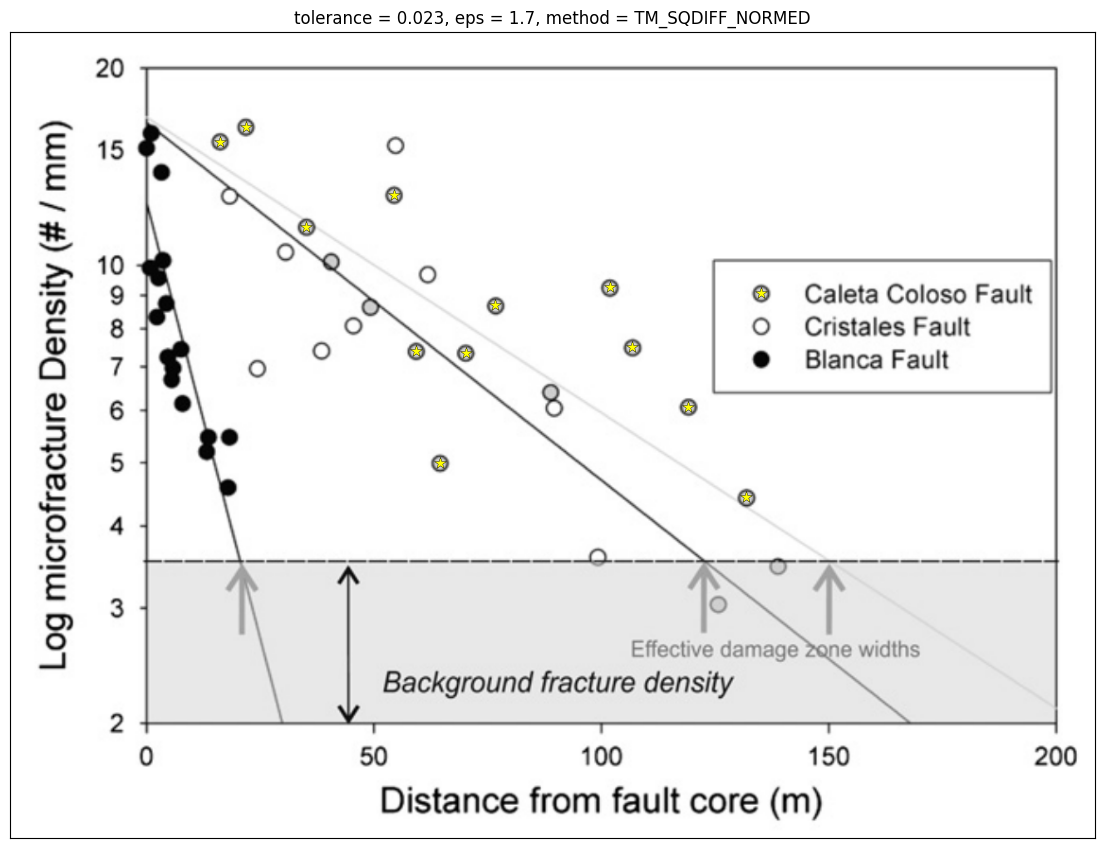

In [18]:
tolerance = 0.023
eps = 1.7

points = detect_points(convolution_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x = actual_points[:, 0]
y = actual_points[:, 1]

## founded points on original image
fig2 = plt.figure(figsize=(14, 14))
draw_image(source_image)
x += w // 2 - 1
y += h // 2 - 1
plt.scatter(x, y, s=80, c="yellow", 
            marker="*", 
            edgecolors='black',
            linewidths=0.3)
plt.xticks([]); plt.yticks([]);
plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")
plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

In [453]:
# fig2.savefig(
#     DATA_PATH / "results" / "detected_points_png" / f"detection_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
# )

# np.savetxt(
#     DATA_PATH / "results" / "coordinates_detected_csv" / f"coords_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.csv",
#     actual_points,
#     delimiter=","
# )

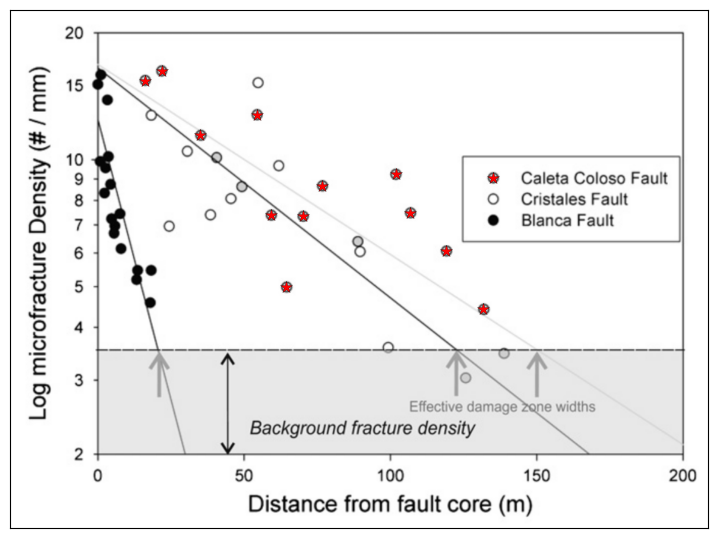

In [21]:
tolerance = 0.023
eps = 1.7

points = detect_points(convolution_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x = actual_points[:, 0]
y = actual_points[:, 1]

## founded points on original image
fig2 = plt.figure(figsize=(9, 9))
draw_image(source_image)
x += w // 2 - 1
y += h // 2 - 1
plt.scatter(x, y, s=80, c="red", 
            marker="*", 
            edgecolors='black',
            linewidths=0.2)
plt.xticks([]); plt.yticks([]);
# plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")
plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

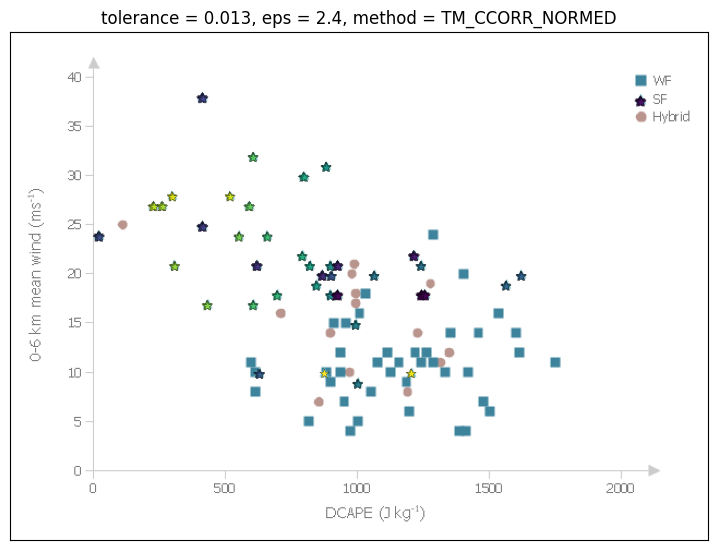

In [71]:
tolerance = 0.013
eps = 2.4

points = detect_points(convolution_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x1 = actual_points[:, 0]
y1 = actual_points[:, 1]
x = points[:, 0]
y = points[:, 1]

# cluster_labels = cluster_labels.astype(object)
# cluster_labels[np.where(cluster_labels == 14)] = "yellow"
# cluster_labels = list(cluster_labels)
# cluster_labels[-1] = "C0"

## founded points on original image
fig2 = plt.figure(figsize=(9, 9))
draw_image(source_image)
x += w // 2
y += h // 2
plt.scatter(x, y, s=50, c=cluster_labels,
            marker="*", 
            edgecolors='black',
            linewidths=0.2)
plt.xticks([]); plt.yticks([]);
plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")


# used_labels = set()
# for i in range(len(cluster_labels)):
#     if cluster_labels[i] not in used_labels:
#         plt.text(x[i] + 1, y[i] - 1, f'{cluster_labels[i]}', fontsize=10)
#     used_labels.add(cluster_labels[i])


plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

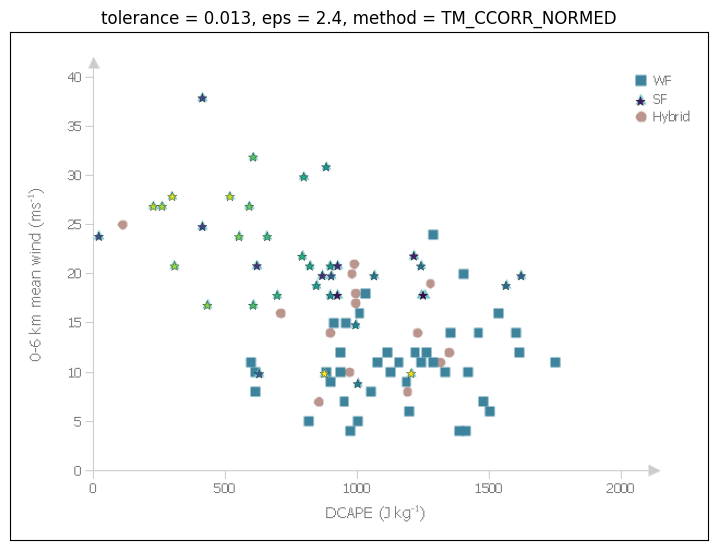

In [73]:
tolerance = 0.013
eps = 2.4

points = detect_points(convolution_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x1 = actual_points[:, 0]
y1 = actual_points[:, 1]
x = points[:, 0]
y = points[:, 1]

# cluster_labels = cluster_labels.astype(object)
# cluster_labels[np.where(cluster_labels == 14)] = "yellow"
# cluster_labels = list(cluster_labels)
# cluster_labels[-1] = "C0"

## founded points on original image
fig2 = plt.figure(figsize=(9, 9))
draw_image(source_image)
x1 += w // 2
y1 += h // 2
plt.scatter(x1, y1, s=50, c=np.unique(cluster_labels),
            marker="*", 
            edgecolors='black',
            linewidths=0.2)
plt.xticks([]); plt.yticks([]);
plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")


# used_labels = set()
# for i in range(len(cluster_labels)):
#     if cluster_labels[i] not in used_labels:
#         plt.text(x[i] + 1, y[i] - 1, f'{cluster_labels[i]}', fontsize=10)
#     used_labels.add(cluster_labels[i])


plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

In [50]:
cluster_labels[np.where(cluster_labels == 3) = 36

(array([66, 69, 70, 71, 74, 75, 76]),)

## Step-by-step marker template processing

In [19]:
PLOT_NUMBER = 6
MARKER_NUMBER = 3

# PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

### 0) Treshholding

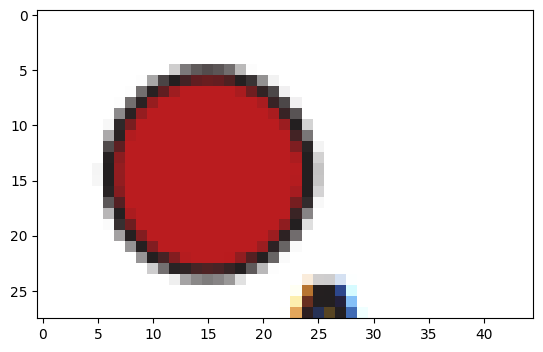

In [20]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

In [21]:
mask = template_tresholding(template_rgb, treshold=200)

In [22]:
### mask for debugging ###

# path_to_mask = str(DATA_PATH / "markers_orig" / "mask_example2.png")
# mask = cv.imread(path_to_mask)

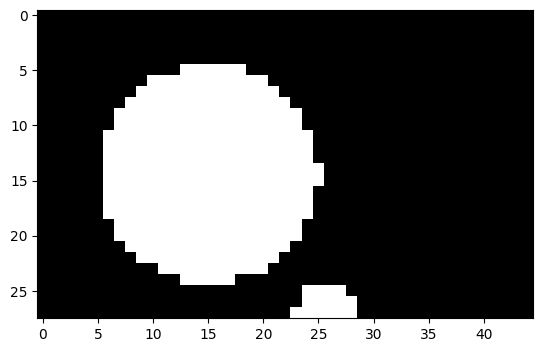

In [23]:
plt.imshow(mask, cmap="gray")

### 1) Find largest connected component

In [24]:
new_mask = extract_largest_component(mask)

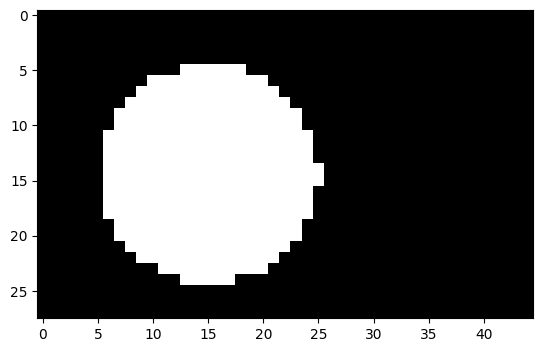

In [25]:
plt.imshow(new_mask, cmap="gray")

### 2) Find bbox around white component

In [42]:
bbox, bbox_center = find_bbox(new_mask)

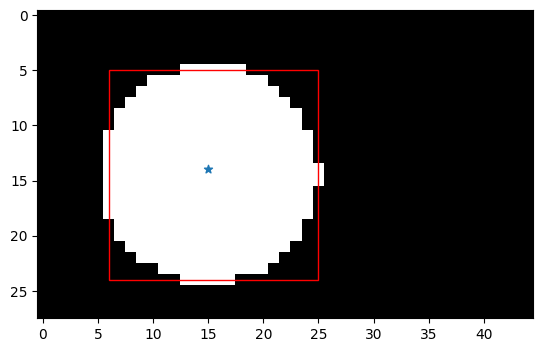

In [44]:
plt.imshow(new_mask, cmap="gray")

draw_bbox(*bbox, bbox_center=bbox_center)

### 3) Crop white component

In [28]:
cropped_mask = crop_image(new_mask, bbox)

cropped_template = crop_image(template_rgb, bbox)

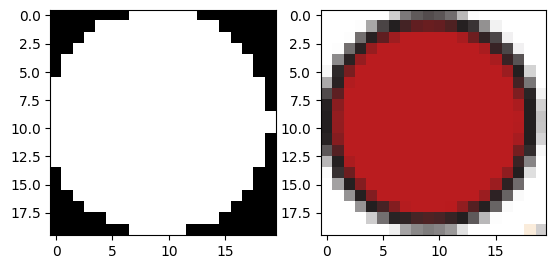

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(cropped_mask, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(cropped_template)

### 4) Add black frames

In [30]:
mask_final = frame_image(cropped_mask, frame_width=2)

template_final = frame_image(cropped_template, frame_width=2)

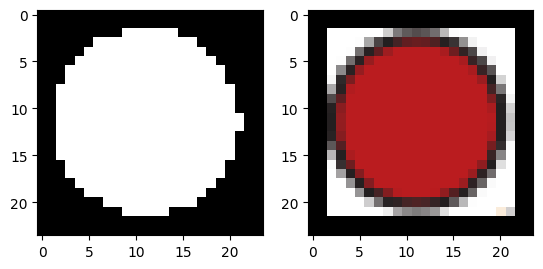

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(mask_final, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(template_final)

## Multi-template matching

In [6]:
PLOT_NUMBER = 6
MARKER_NUMBERS = [1, 2, 3]

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"

TEMPLATE_PATHS = [DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUM}.png"
                  for MARKER_NUM in MARKER_NUMBERS]

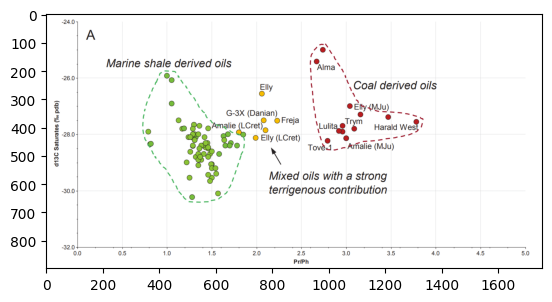

In [7]:
source_image = read_image_rgb(PLOT_PATH)
draw_image(source_image)

In [8]:
templates = [read_image_rgb(TEMPLATE_PATH) for TEMPLATE_PATH in TEMPLATE_PATHS]


# lists of template shapes
w_list = [template.shape[1] for template in templates]
h_list = [template.shape[0] for template in templates]

w = w_list[0]
h = h_list[0]

for i in range(len(w_list) - 1):
    assert w_list[i] == w_list[i+1], "templates have different shapes"
    assert h_list[i] == h_list[i+1], "templates have different shapes"

Text(0.5, 1.0, 'template 2')

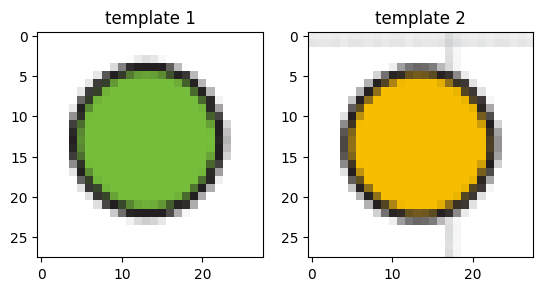

In [10]:
plt.subplot(1, 2, 1)
draw_image(templates[0])
plt.title("template 1")

plt.subplot(1, 2, 2)
draw_image(templates[1])
plt.title("template 2")

In [11]:
masks = [template_tresholding(template, treshold=200) for template in templates]

Text(0.5, 1.0, 'template 2')

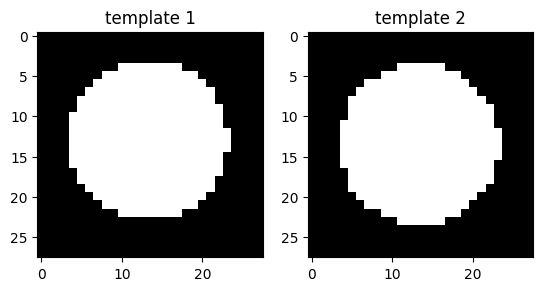

In [12]:
plt.subplot(1, 2, 1)
draw_image(masks[0])
plt.title("template 1")

plt.subplot(1, 2, 2)
draw_image(masks[1])
plt.title("template 2")

In [13]:
from template_match import invert_convolution_map


def multi_template_match(
    image: np.ndarray,
    templates: List[np.ndarray],
    template_masks: List[np.ndarray],
    method_name: str
) -> Tuple[List[np.ndarray], List[float]]:
    """ 
    Run opencv templateMatch on each template from list of templates.
    Return list of convolution maps and list of maximum values on each map.
    """
    method = eval(method_name)

    convolution_map_list = []
    max_val_list = []

    for template, template_mask in zip(templates, template_masks):

        convolution_map = cv.matchTemplate(image, template, method, mask=template_mask)
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED, cv.TM_CCORR]:
            logger.debug(f"Convolution map bounds: {np.min(convolution_map), np.max(convolution_map)}")
            logger.debug("Convolution map was inverted")
            convolution_map = invert_convolution_map(convolution_map)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(convolution_map)

        convolution_map_list.append(convolution_map)
        max_val_list.append(max_val)

    return convolution_map_list, max_val_list


In [14]:
def get_best_matches(convolution_map_list: List[np.ndarray]) -> np.ndarray:
    """
    Idea: At ech pixel of source image find which template gives
            maximum correlation value during template matching process.

    Return 2d array of the same size as convolution map.
    Each array value represents number of template (<=> label) that gives best match at this position. 
    """
    stacked_conv_maps = np.stack(convolution_map_list)

    # best_match_corr_values = np.max(stacked_conv_maps, axis=0)
    best_match_template_numbers = np.argmax(stacked_conv_maps, axis=0)
    return best_match_template_numbers

In [15]:
def detect_points_v2(
    convolution_map: np.ndarray,
    max_value: float,
    tolerance: float,
    best_match_map: np.ndarray,
    template_number: int
) -> np.ndarray:
    
    max_positions = np.where( np.isclose(convolution_map, max_value, atol=tolerance) )
    y, x = max_positions
    max_points = np.array([x, y]).T
    
    allowed_positions = np.where( best_match_map == template_number )

    if len(allowed_positions[0]) == 0:
        logger.warning("Template had not any best matches")
        return max_points

    else:
        y, x = allowed_positions
        points_with_allowed_positions = np.array([x, y]).T
        points = npi.intersection(max_points, points_with_allowed_positions)
        return points

In [26]:
%%time
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

method = 'cv.TM_CCORR_NORMED'
# method = 'cv.TM_SQDIFF_NORMED'

# method = 'cv.TM_CCOEFF_NORMED'
# method = 'cv.TM_SQDIFF'


convolution_map_list, max_val_list = multi_template_match(
    source_image, templates, masks, method_name=method
)


# convolution_map1, max_val1 = template_match(source_image, template1, mask1, method_name=method)
# convolution_map2, max_val2 = template_match(source_image, template2, mask2, method_name=method)
# assert convolution_map1.shape == convolution_map2.shape, "Corr map shapes are different"
# conv_map_height, conv_map_width = convolution_map1.shape

CPU times: user 259 ms, sys: 2.82 ms, total: 262 ms
Wall time: 285 ms


In [53]:
# # check that all conv maps have same shape
# for i in range(len(convolution_map_list) - 1):
#     assert convolution_map_list[i].shape == convolution_map_list[i+1].shape

#     # check that conv map differs (optional)
#     assert not np.all(convolution_map_list[i] == convolution_map_list[i+1])


In [19]:
best_match_map = get_best_matches(convolution_map_list)

np.unique(best_match_map, return_counts=True)

(array([0, 1, 2, 3]), array([   774, 967586,  65463,    683]))

In [20]:
MARKER_NUMBER = 3
TEMPLATE_NUM = MARKER_NUMBER - 1

convolution_map = convolution_map_list[TEMPLATE_NUM]
max_val = max_val_list[TEMPLATE_NUM]

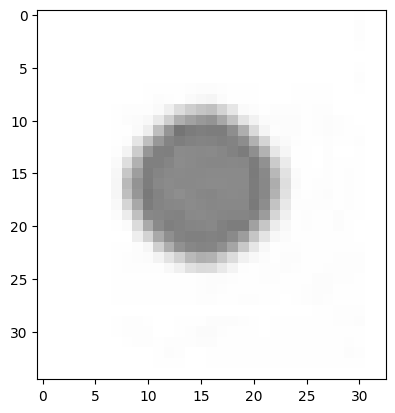

In [21]:
draw_image(templates[TEMPLATE_NUM])

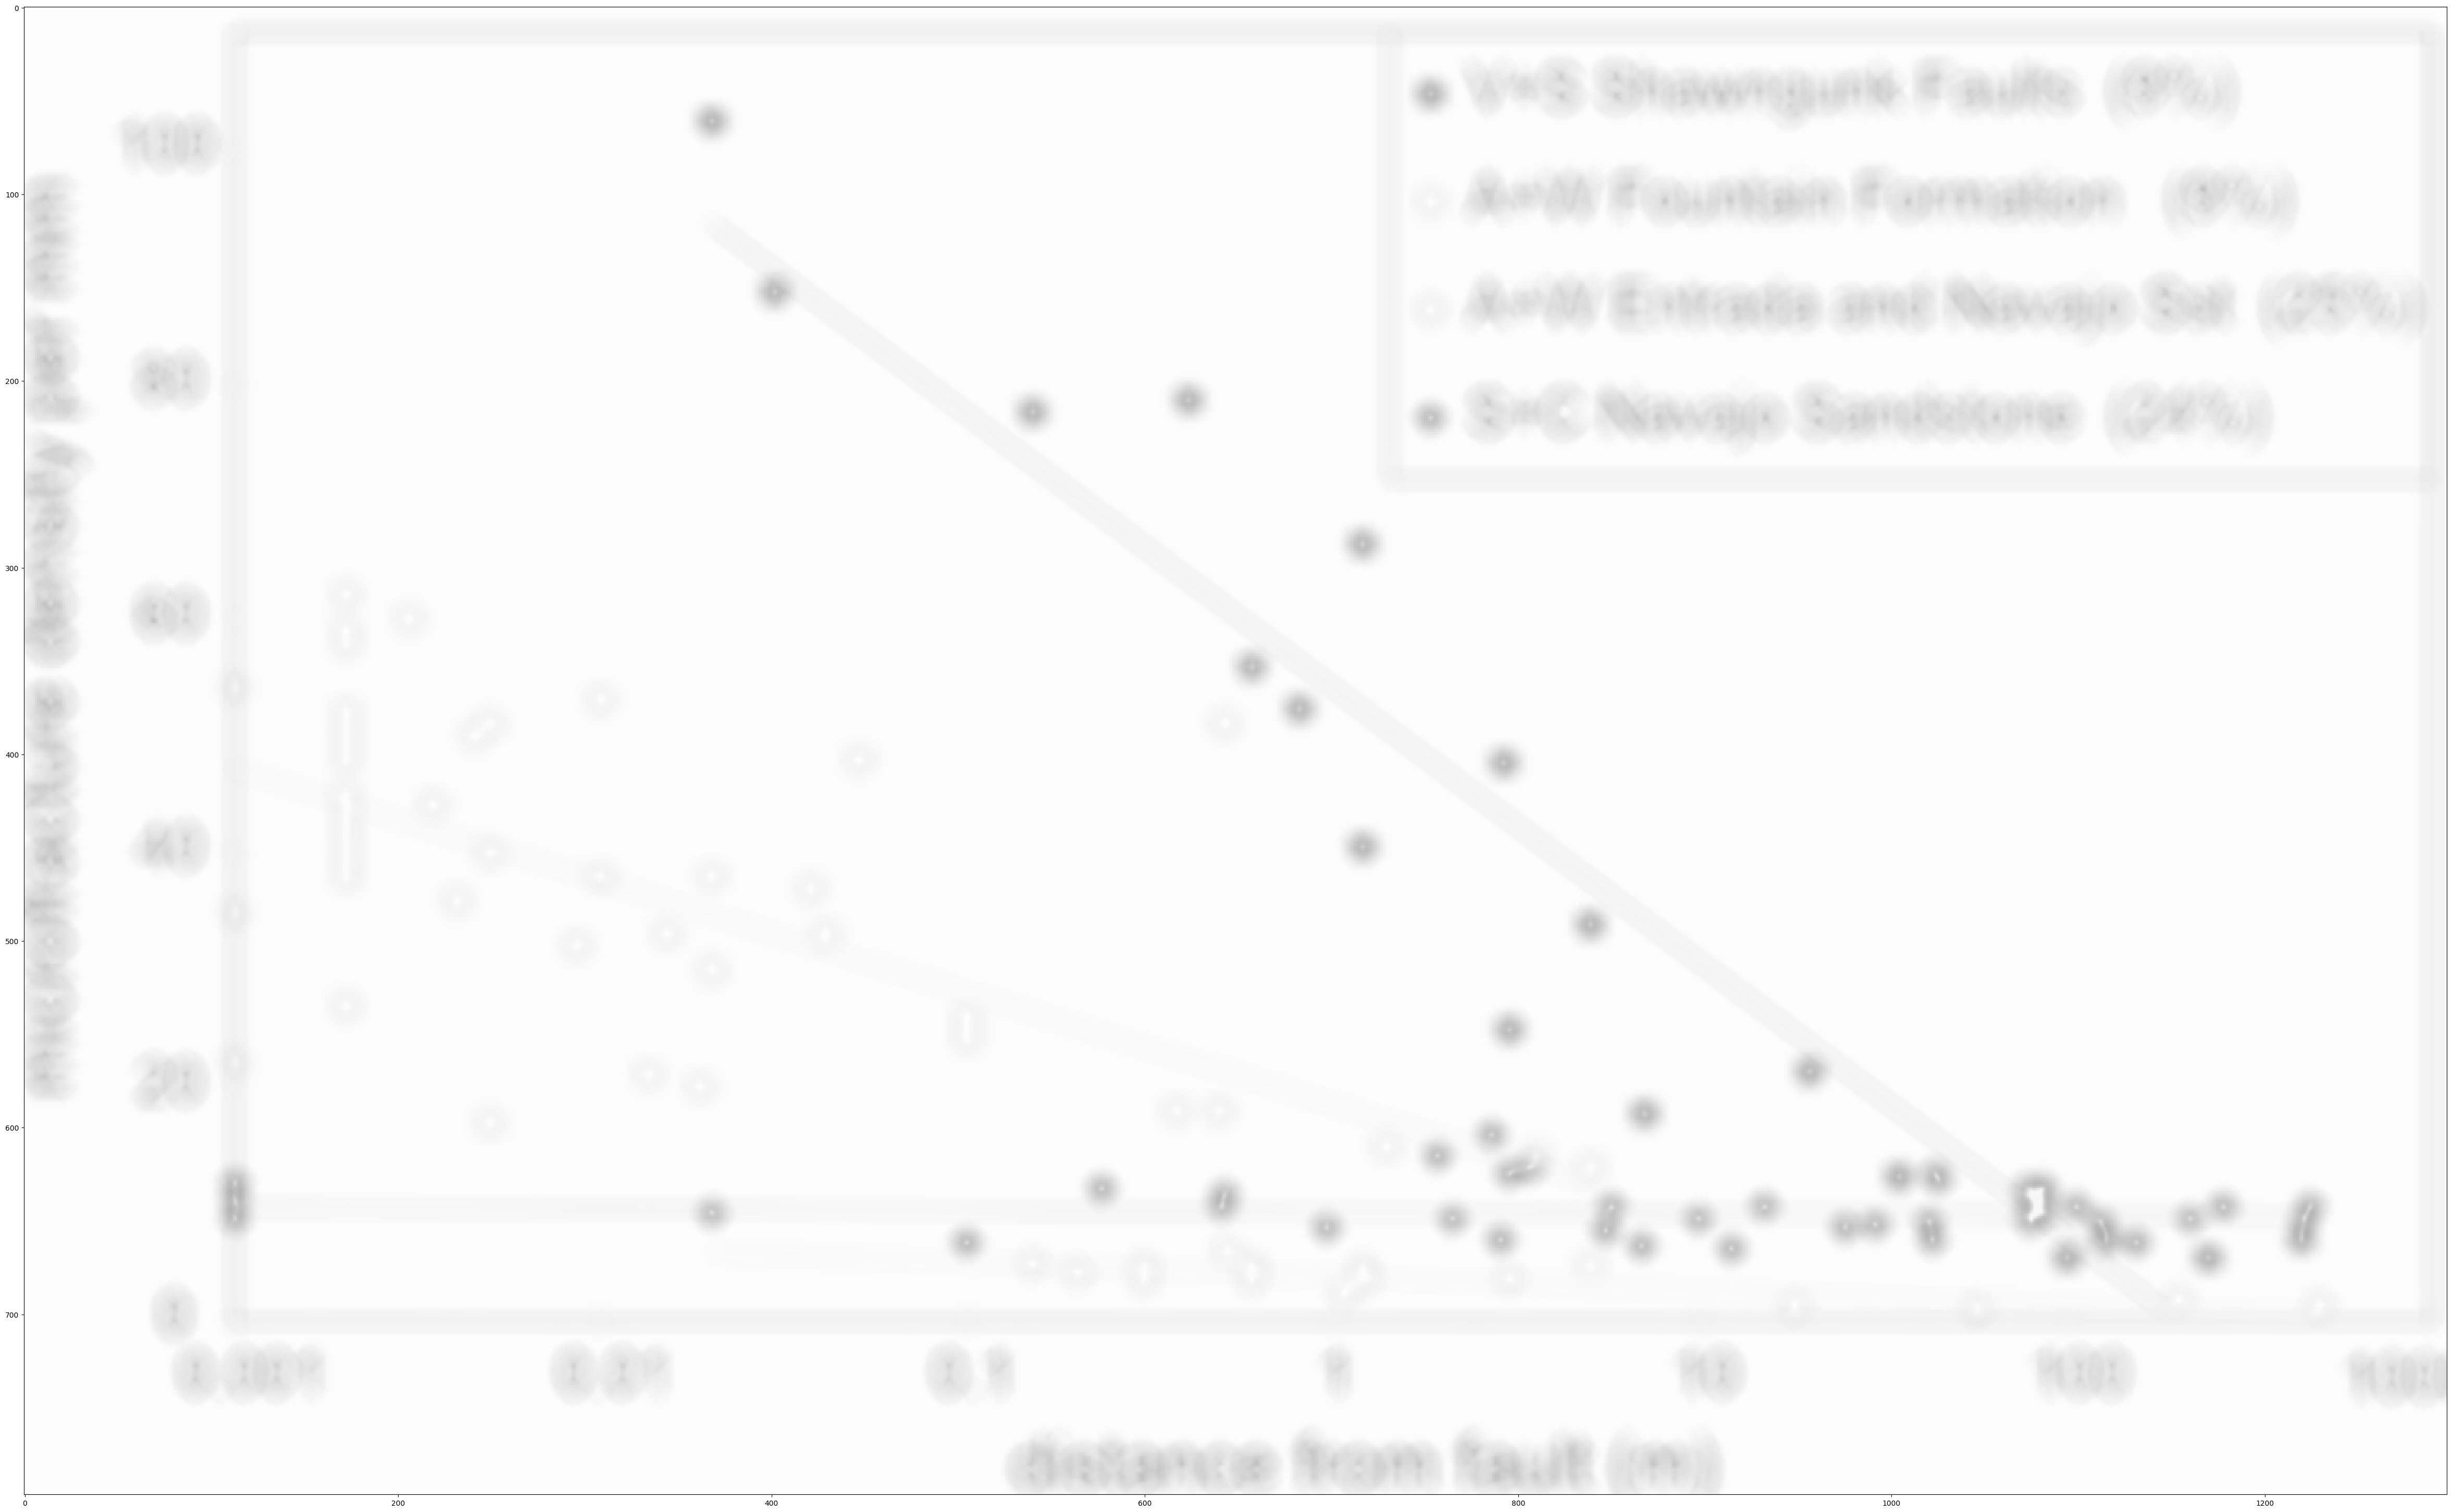

In [22]:
plt.figure(figsize=(60, 40))
draw_image(convolution_map)

# draw_image(convolution_map / np.max(convolution_map))

### Detect points example

In [31]:
tolerance = 0.003

points = detect_points_v2(
    convolution_map, max_val, tolerance,
    best_match_map, TEMPLATE_NUM
)

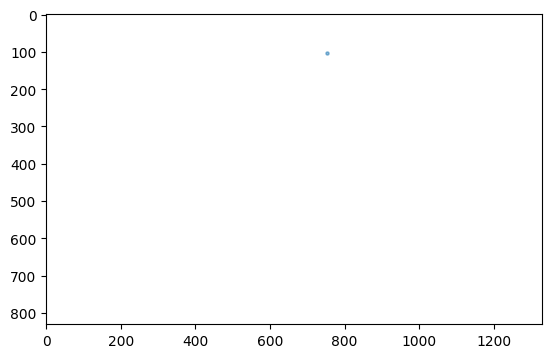

In [20]:
draw_points_on_canvas(points, source_image)

### Find detection tolerance limit

In [23]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

0.009000000000000001

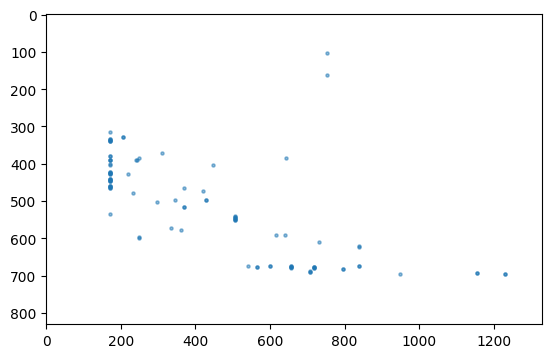

In [24]:
# run detection with limit tolerance value
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)

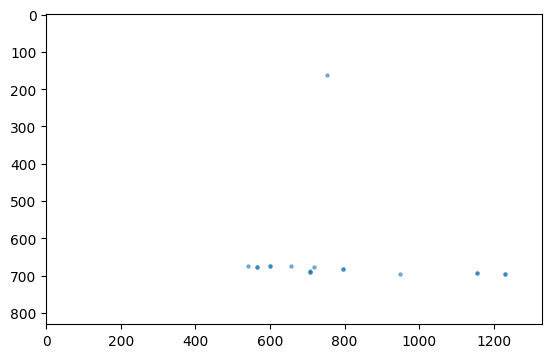

In [25]:
points = detect_points_v2(
    convolution_map, max_val, tolerance_limit,
    best_match_map, TEMPLATE_NUM
)
draw_points_on_canvas(points, source_image)

### Select best tolerance and eps


Need gloabal variables `best_match_map`, `TEMPLATE_NUM`, `convolution_map`, `max_val`, `w`, `h`

In [26]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.009000000000000001, min=0.001, s…

In [66]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    # points = detect_points_v2(convolution_map, max_val, tolerance=tolerance)
    points = detect_points_v2(
        convolution_map, max_val, tolerance,
        best_match_map, TEMPLATE_NUM
    )

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.009000000000000001, min=0.001, s…

## Drafts

In [29]:
# draw_image(convolution_map_list[0])

In [52]:
[convolution_map_list[i][0, 1] for i in range(len(convolution_map_list))]

[0.99642336, 0.9903809]

In [92]:
%%time
conv_map_height, conv_map_width = convolution_map_list[0].shape
max_label_map = np.zeros_like(convolution_map_list[0], dtype=np.int32)
max_corr_map = np.zeros_like(convolution_map_list[0], dtype=np.float64)  # like max NCC in article 


for h in range(conv_map_height):
    for w in range(conv_map_width):
        conv_map_values = [convolution_map_list[i][h, w] for i in range(len(convolution_map_list))]
        
        assert len(conv_map_values) == 2
        max_corr_map[h, w] = np.max(conv_map_values)
        max_label_map[h, w] = np.argmax(conv_map_values)


np.unique(max_label_map, return_counts=True)

CPU times: user 7.33 s, sys: 0 ns, total: 7.33 s
Wall time: 7.33 s


(array([0, 1], dtype=int32), array([967963,  66543]))

In [76]:
%%time
label_map = np.zeros_like(convolution_map_list[0], dtype=np.int32)

for h in range(conv_map_height):
    for w in range(conv_map_width):
        conv_map_value1 = convolution_map_list[0][h, w]
        conv_map_value2 = convolution_map_list[1][h, w]

        if conv_map_value1 > conv_map_value2:
            label_map[h, w] = 1
        elif conv_map_value2 > conv_map_value1:
            label_map[h, w] = 2

np.unique(label_map, return_counts=True)

CPU times: user 725 ms, sys: 0 ns, total: 725 ms
Wall time: 723 ms


(array([1, 2], dtype=int32), array([967963,  66543]))

In [75]:
%%time
stacked_conv_maps = np.stack(convolution_map_list)

max_val_from_stacked_conv_maps = np.max(stacked_conv_maps, axis=0)

max_labels_from_stacked_conv_maps = np.argmax(stacked_conv_maps, axis=0)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 23.6 ms


In [96]:
np.all( max_val_from_stacked_conv_maps == max_corr_map )

True

In [93]:
np.all(max_label_map == max_labels_from_stacked_conv_maps)

True

In [191]:
tolerance = 0.01

In [192]:
_, max_val1, _, _ = cv.minMaxLoc(convolution_map2)
max_val1

1.0

In [193]:
max_positions1 = np.where( np.isclose(convolution_map2, max_val1, atol=tolerance) )
y, x = max_positions1
points = np.array([x, y]).T

In [194]:
points.shape

(731102, 2)

In [195]:
allowed_positions = np.where( label_map == 2 )
y, x = allowed_positions
allowed_positions_points = np.array([x, y]).T
allowed_positions_points.shape

(66543, 2)

In [ ]:
intersection = npi.intersection(points, allowed_positions_points)
intersection

In [196]:
# ## slower way to search intersection
# %%time
# b_set = set([tuple(x) for x in allowed_positions_points])
# a_set = set([tuple(x) for x in points])

# intersection = np.array([x for x in a_set & b_set])

CPU times: user 1.28 s, sys: 21 ms, total: 1.3 s
Wall time: 1.3 s


In [197]:
# intersection

In [109]:
A = np.array([[1, 4],
              [2, 5],
              [3, 6]])

B = np.array([[1, 4],
              [3, 6], 
              [7, 8]])

b_set = set([tuple(x) for x in B])
a_set = set([tuple(x) for x in A])

b_set

{(1, 4), (3, 6), (7, 8)}

In [110]:
np.array([x for x in a_set & b_set])

array([[1, 4],
       [3, 6]])

In [49]:
A = np.array([[1, 4],
              [2, 5],
              [3, 6]])

B = np.array([[2, 3],
              [3, 6], 
              [7, 8]])

C = np.array([[2, 3],
              [3, 6990], 
              [7, 8]])

D = np.array([[2, 3],
              [33, 6], 
              [7, 8]])

In [67]:
stacked2 = np.stack([A, B, C, D])

True

In [50]:
stacked = np.stack([A, B, C, D])

# stacked[:, 0, 0]
stacked

np.max(stacked, axis=0)

array([[[   1,    4],
        [   2,    5],
        [   3,    6]],

       [[   2,    3],
        [   3,    6],
        [   7,    8]],

       [[   2,    3],
        [   3, 6990],
        [   7,    8]],

       [[   2,    3],
        [  33,    6],
        [   7,    8]]])

In [51]:
np.max(stacked, axis=0)

array([[   2,    4],
       [  33, 6990],
       [   7,    8]])

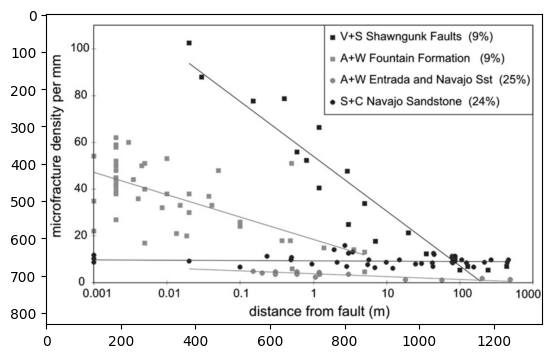

In [9]:
source_image = read_image_gray(PLOT_PATH)
draw_image(source_image)

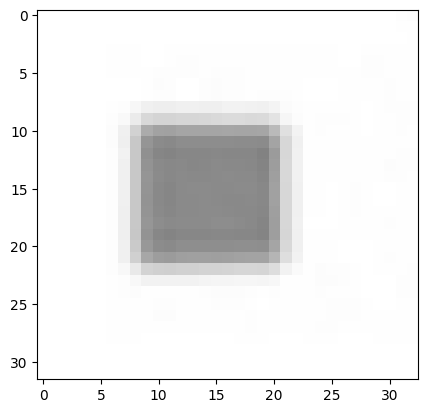

In [10]:
template = read_image_gray(TEMPLATE_PATH)
draw_image(template)

In [19]:
a = np.array([[1, 2, 3],
              [4, 2, 5]])

b = np.array([[3, 1, 4],
              [2, 5, 1]])

c = [a, b]

c = np.array(c)
c

array([[[1, 2, 3],
        [4, 2, 5]],

       [[3, 1, 4],
        [2, 5, 1]]])

In [21]:
c.shape

(2, 2, 3)

In [24]:
np.max(c, axis=0)

array([[3, 2, 4],
       [4, 5, 5]])

In [ ]:
a = np.array([[1, 2],
              [3, 4],
              [5, 6]])


np.pad(a, pad_width=, mode="constant")